In [33]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import argparse
import torch

from model import get_model
from utils import read_json_data, attn_mask, attention

In [34]:
epoch = 499
gpu_id = 3

In [35]:
root_path = 'result/GPT_test_L4/3x_to_x-seed_1-N_2048-nh_128-dh_4-varff_0.001-varattn_0.001-lr_0.0002/'
model_dir = f'{root_path}/model/model_{epoch}.pt'
traindata_dir = f'{root_path}/data/train.npz'
args_dir = f'{root_path}/config.json'
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")

In [36]:
args = read_json_data(args_dir)
args = argparse.Namespace(**args)
N_layers = args.n_layers
model = get_model(args, device)
model_dict = torch.load(model_dir)
model.load_state_dict(model_dict)
model.to(device)
train_data = np.load(traindata_dir)['full data']

In [37]:
input_X = torch.from_numpy(train_data[0]).to(device)
input_X = input_X.unsqueeze(0)
decoder_layers = model.decoder.layers
hidden_state = model.embedding(input_X)
dec_self_attn_mask = attn_mask(input_X, device)

In [38]:
outputs_dict = defaultdict(list)
attentions_dict = defaultdict(list)
for layer_id in range(N_layers):
    attn = decoder_layers[layer_id].dec_self_attn
    qxs = attn.W_Q(hidden_state).chunk(args.n_heads, dim=-1) 
    kxs = attn.W_K(hidden_state).chunk(args.n_heads, dim=-1) 
    vxs = attn.W_V(hidden_state).chunk(args.n_heads, dim=-1)
    hidden_state,_ = decoder_layers[0](hidden_state, dec_self_attn_mask)
    for i in range(len(qxs)):
        attn_out = attention(dec_self_attn_mask, qxs[i], kxs[i], vxs[i])
        outputs_dict[layer_id].append(attn_out[0])
        attentions_dict[layer_id].append(attn_out[1])

In [39]:
def mat_cos_similarity(mat1,mat2):
    mat1 = mat1.reshape(-1,1).squeeze()
    mat2 = mat2.reshape(-1,1).squeeze()
    cos = torch.cosine_similarity(mat1, mat2, dim=0)
    return cos
def paint_attn_heatmap(attn):
    if type(attn) is torch.Tensor:
        attn = attn.detach().cpu().numpy()
        attn = attn.squeeze()
    plt.imshow(attn)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [40]:
def order_exchange(heatmap_out, threshold):
    order = []
    size = heatmap_out.shape[0]
    order1 = list(range(size))
    k = 0
    order_temp = []

    order1 = []
    for j in range(size):
        if j != 0:
            for i in order2:
                if heatmap_out[k][i] > threshold:
                    order.append(i)
                else:
                    order1.append(i)
        else:
            for i in range(size):
                if heatmap_out[0][i] > threshold:
                    order.append(i)
                else:
                    order1.append(i)

        order_temp = order_temp + order
        if len(order_temp) == size:
            break
        k = order1[0]
        order2 = order1
        order1 = []
        order = []

    return order_temp

In [68]:
# 0:out, 1:attn, 2:vx
src_id = 2
src_names = ['head_output', 'head_attention', 'V(X)']
thre = 0.8

In [69]:
out_simi_all = np.ones((N_layers,128,128))
attn_simi_all = np.ones((N_layers,128,128))
vx_simi_all = np.ones((N_layers,128,128))
for layer_id in range(N_layers):
    outputs = outputs_dict[layer_id]
    attentions = attentions_dict[layer_id]
    out_simi = out_simi_all[layer_id]
    attn_simi = attn_simi_all[layer_id]
    vx_simi = vx_simi_all[layer_id]
    for i in range(128):
        for j in range(i,128):
            cos_out = mat_cos_similarity(outputs[i],outputs[j])
            cos_attn = mat_cos_similarity(attentions[i],attentions[j])
            cos_vx = mat_cos_similarity(vxs[i],vxs[j])
            out_simi[i,j] = cos_out
            out_simi[j,i] = cos_out
            attn_simi[i,j] = cos_attn
            attn_simi[j,i] = cos_attn
            vx_simi[i,j] = cos_vx
            vx_simi[j,i] = cos_vx
    order_src = [out_simi, attn_simi, vx_simi]
    changed_order = order_exchange(order_src[src_id], thre)
    out_simi = out_simi[changed_order,:]
    out_simi = out_simi[:,changed_order]
    attn_simi = attn_simi[changed_order,:]
    attn_simi = attn_simi[:,changed_order]
    vx_simi = vx_simi[changed_order,:]
    vx_simi = vx_simi[:,changed_order]
    out_simi_all[layer_id] = out_simi
    attn_simi_all[layer_id] = attn_simi
    vx_simi_all[layer_id] = vx_simi

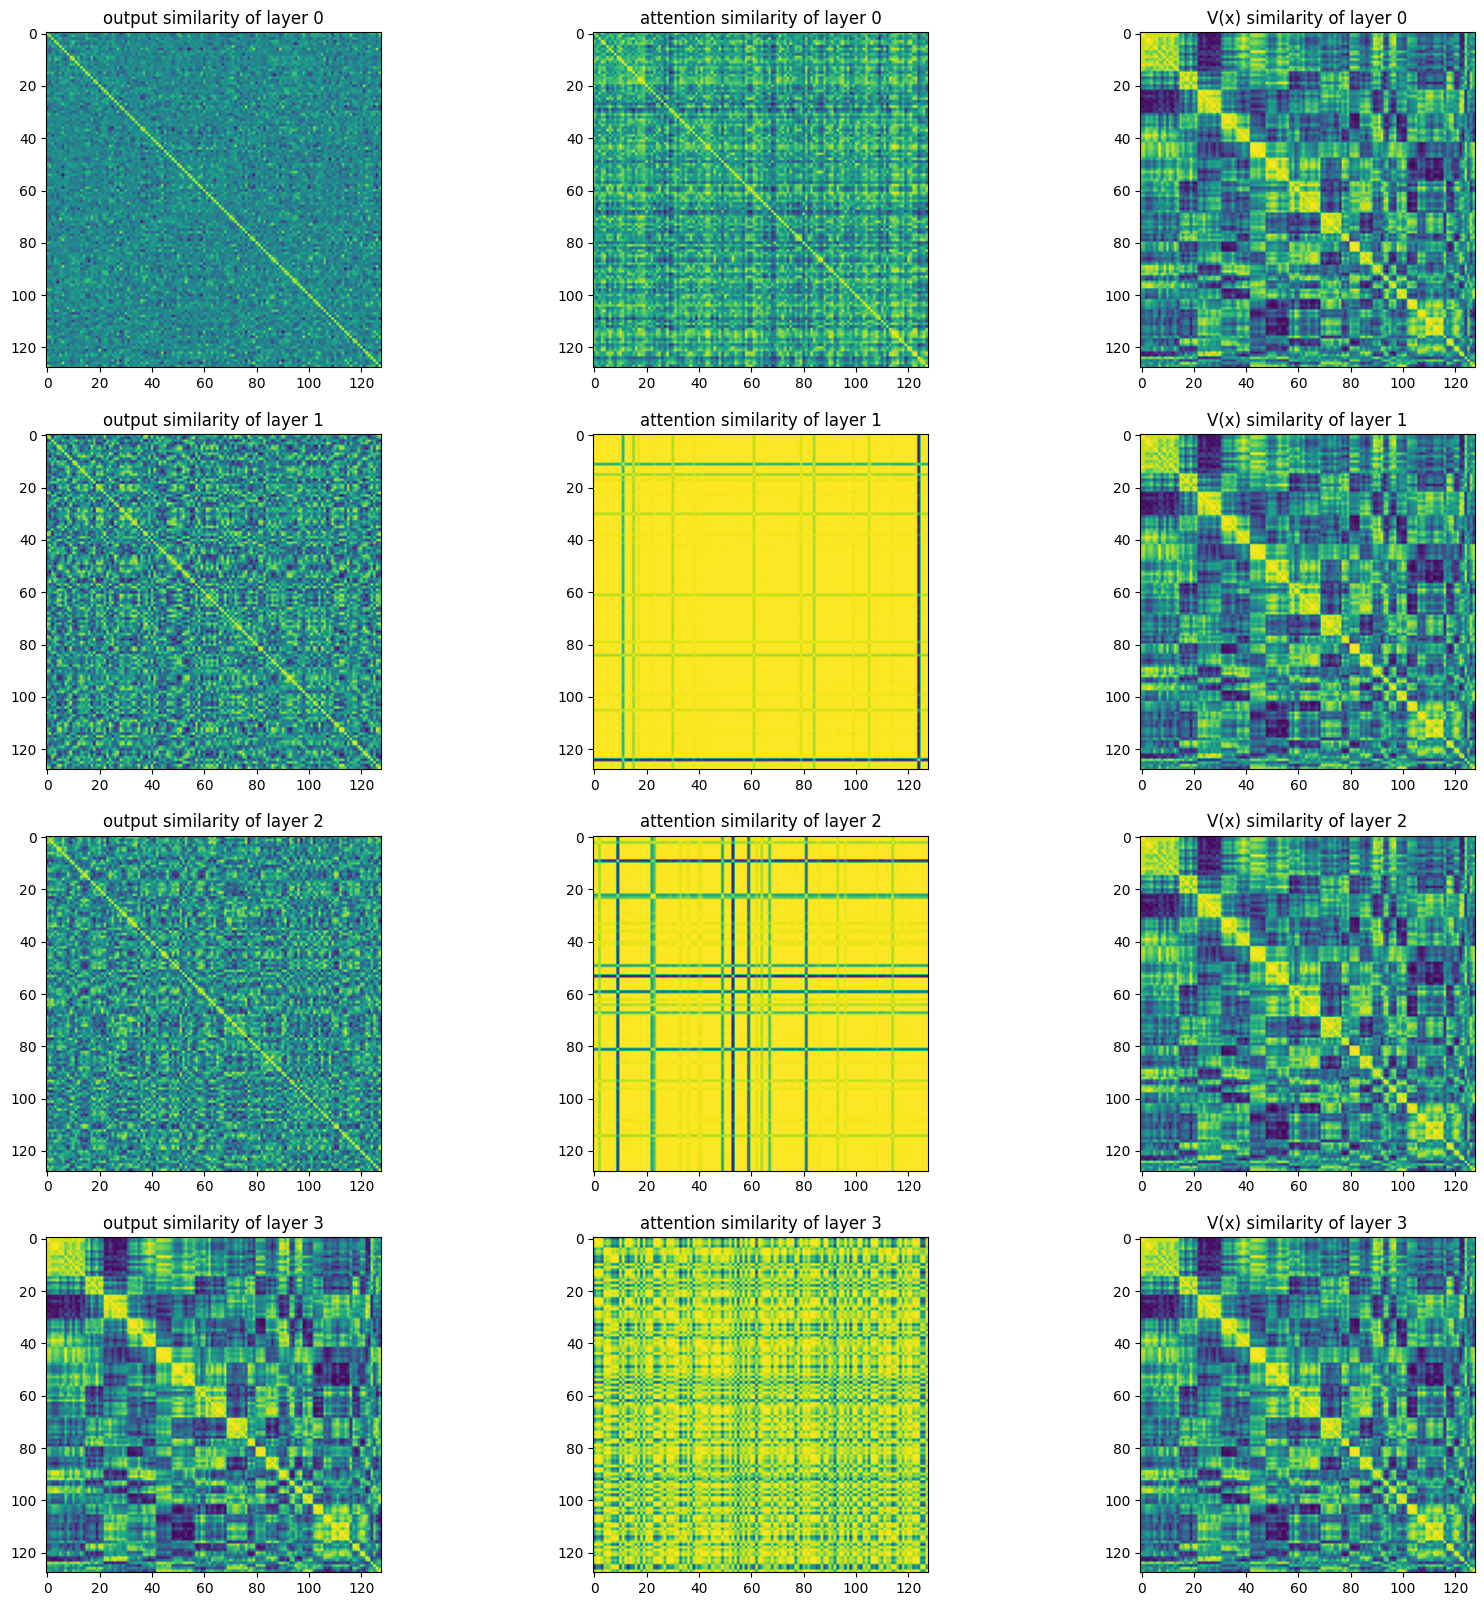

In [70]:
plt.figure(figsize=(20,20))
for layer_id in range(N_layers):
    plt.subplot(N_layers,3,layer_id*3+1)
    plt.title('output similarity of layer {}'.format(layer_id))
    plt.imshow(out_simi_all[layer_id])
    plt.subplot(N_layers,3,layer_id*3+2)
    plt.title('attention similarity of layer {}'.format(layer_id))
    plt.imshow(attn_simi_all[layer_id])
    plt.subplot(N_layers,3,layer_id*3+3)
    plt.title('V(x) similarity of layer {}'.format(layer_id))
    plt.imshow(vx_simi_all[layer_id])
plt.savefig(f'{root_path}/pic/train_{src_names[src_id]}_{epoch}.png')
plt.show()